In [ ]:

!git clone https://github.com/openai/CLIP.git
#https://github.com/openai/CLIP 
#CLIP (Contrastive Language-Image Pre-Training) 

!git clone https://github.com/CompVis/taming-transformers  
#https://github.com/CompVis/taming-transformers

Cloning into 'CLIP'...
remote: Enumerating objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 8.92 MiB | 13.05 MiB/s, done.
Resolving deltas: 100% (123/123), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1339, done.
remote: Total 1339 (delta 0), reused 0 (delta 0), pack-reused 1339
Receiving objects: 100% (1339/1339), 409.77 MiB | 31.40 MiB/s, done.
Resolving deltas: 100% (279/279), done.


-->two architecture are in github repositories and we have to download them



In [ ]:
## install some extra libraries
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
!pip uninstall torchtext --yes
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import libraries
import numpy as np
import torch, os, imageio, pdb, math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import yaml 
from omegaconf import OmegaConf

from CLIP import clip

#import warnings
#warnings.filterwarnings('ignore')


tensor-->multi dimentional array of images



In [ ]:
## helper functions

def show_from_tensor(tensor):
  img = tensor.clone()
  img = img.mul(255).byte()
  img = img.cpu().numpy().transpose((1,2,0))

  plt.figure(figsize=(10,7))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

def norm_data(data):
  return (data.clip(-1,1)+1)/2 ### range between 0 and 1 in the result

### Parameters 
learning_rate = .5
batch_size = 1
wd = .1 
noise_factor = .22 
#noise_factor = .1
total_iter=100
#total_iter=400
im_shape = [450, 450, 3] # height, width, channel
#im_shape=[225,400,3]
size1, size2, channels = im_shape


clip model is able to connect text to images
clip internal uses visual transformer
eval() mode is used because we don't want to train clip


In [ ]:
### CLIP MODEL ### 
clipmodel, _ = clip.load('ViT-B/32', jit=False)
clipmodel.eval()
print(clip.available_models())

print("Clip model visual input resolution: ", clipmodel.visual.input_resolution)

device=torch.device("cuda:0")
torch.cuda.empty_cache()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Clip model visual input resolution:  224


we need to download pretrained check points of taming transformer
vqgan is the internal architecture in taming transformer
we should download the pretrained architecture

In [ ]:
## Taming transformer instantiation

%cd taming-transformers/

!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) == 0:
   !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt' 
   !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml' 


/content/taming-transformers/taming-transformers
--2023-05-03 22:49:41--  https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/1ee2638b-e616-46d5-85bb-16645cd7d2bf/last.ckpt [following]
--2023-05-03 22:49:41--  https://heibox.uni-heidelberg.de/seafhttp/files/1ee2638b-e616-46d5-85bb-16645cd7d2bf/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 980092370 (935M) [application/octet-stream]
Saving to: ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’

models/vqgan_imagen 100%[===================>] 934.69M  14.9MB/s    in 62s     

2023-05-03 22:50:43 (15.1 MB/s) - ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’ 

In [ ]:
pip install --upgrade torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


load_config -->to load configuration
 

In [ ]:
from taming.models.vqgan import VQModel

def load_config(config_path, display=False):
   config_data = OmegaConf.load(config_path)
   if display:
     print(yaml.dump(OmegaConf.to_container(config_data)))
   return config_data

def load_vqgan(config, chk_path=None):
  model = VQModel(**config.model.params)
  if chk_path is not None:
    state_dict = torch.load(chk_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
  return model.eval()

def generator(x):
  x = taming_model.post_quant_conv(x)
  x = taming_model.decoder(x)
  return x

taming_config = load_config("./models/vqgan_imagenet_f16_16384/configs/model.yaml", display=True)
taming_model = load_vqgan(taming_config, chk_path="./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)


model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


8.19kB [00:00, 1.91MB/s]                   

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [ ]:
### Declare the values that we are going to optimize

class Parameters(torch.nn.Module):
  def __init__(self):ing
    super(Parameters, self).__init__()
    self.data = .5*torch.randn(batch_size, 256, size1//16, size2//16).cuda() # 1x256x14x15 (225/16, 400/16)
    self.data = torch.nn.Parameter(torch.sin(self.data))

  def forward(self):
    return self.data

def init_params():
  params=Parameters().cuda()
  optimizer = torch.optim.AdamW([{'params':[params.data], 'lr': learning_rate}], weight_decay=wd)
  return params, optimizer



torch.Size([1, 256, 28, 28])
img dimensions:  torch.Size([1, 3, 448, 448])


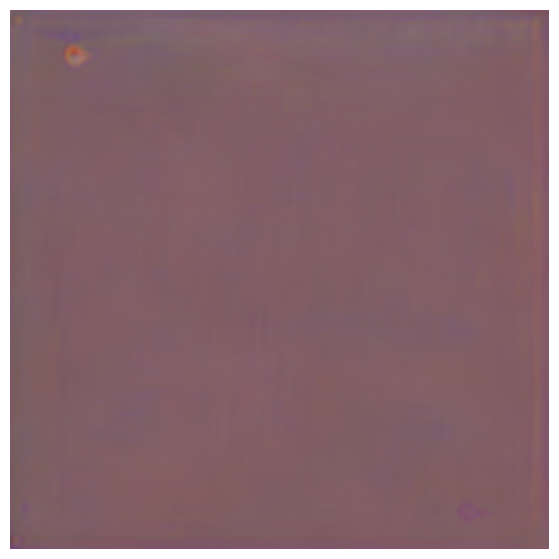

In [ ]:
### Encoding prompts and a few more things
normalize = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

def encodeText(text):
  t=clip.tokenize(text).cuda()
  t=clipmodel.encode_text(t).detach().clone()
  return t

def createEncodings(include, exclude, extras):
  include_enc=[]
  for text in include:
    include_enc.append(encodeText(text))
  exclude_enc=encodeText(exclude) if exclude != '' else 0
  extras_enc=encodeText(extras) if extras !='' else 0

  return include_enc, exclude_enc, extras_enc

augTransform = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30, (.2, .2), fill=0)  
).cuda()

Params, optimizer = init_params()

with torch.no_grad():
  print(Params().shape)
  img= norm_data(generator(Params()).cpu()) # 1 x 3 x 224 x 400 [225 x 400]
  print("img dimensions: ",img.shape)
  show_from_tensor(img[0])



In [ ]:
### create crops

def create_crops(img, num_crops=32): 
  p=size1//2
  img = torch.nn.functional.pad(img, (p,p,p,p), mode='constant', value=0) # 1 x 3 x 448 x 624 (adding 112*2 on all sides to 224x400)

  img = augTransform(img) #RandomHorizontalFlip and RandomAffine

  crop_set = []
  for ch in range(num_crops):
    gap1= int(torch.normal(1.2, .3, ()).clip(.43, 1.9) * size1)
    offsetx = torch.randint(0, int(size1*2-gap1),())
    offsety = torch.randint(0, int(size1*2-gap1),())

    crop=img[:,:,offsetx:offsetx+gap1, offsety:offsety+gap1]

    crop = torch.nn.functional.interpolate(crop,(224,224), mode='bilinear', align_corners=True)
    crop_set.append(crop)

  img_crops=torch.cat(crop_set,0) ## 30 x 3 x 224 x 224

  randnormal = torch.randn_like(img_crops, requires_grad=False)
  num_rands=0
  randstotal=torch.rand((img_crops.shape[0],1,1,1)).cuda() #32
  
  for ns in range(num_rands):
    randstotal*=torch.rand((img_crops.shape[0],1,1,1)).cuda()

  img_crops = img_crops + noise_factor*randstotal*randnormal

  return img_crops




In [ ]:
### Show current state of generation

def showme(Params, show_crop):
  with torch.no_grad():
    generated = generator(Params())

    if (show_crop):
      print("Augmented cropped example")
      aug_gen = generated.float() # 1 x 3 x 224 x 400 
      aug_gen = create_crops(aug_gen, num_crops=1)
      aug_gen_norm = norm_data(aug_gen[0])
      show_from_tensor(aug_gen_norm)

    print("Generation")
    latest_gen=norm_data(generated.cpu()) # 1 x 3 x 224 x 400
    show_from_tensor(latest_gen[0])

  return (latest_gen[0]) 

In [ ]:
# Optimization process

def optimize_result(Params, prompt):
  alpha=1 ## the importance of the include encodings
  beta=.5 ## the importance of the exclude encodings

  ## image encoding
  out = generator(Params())
  out = norm_data(out)
  out = create_crops(out)
  out = normalize(out) # 30 x 3 x 224 x 224
  image_enc=clipmodel.encode_image(out) ## 30 x 512

  ## text encoding  w1 and w2
  final_enc = w1*prompt + w1*extras_enc # prompt and extras_enc : 1 x 512
  final_text_include_enc = final_enc / final_enc.norm(dim=-1, keepdim=True) # 1 x 512
  final_text_exclude_enc = exclude_enc

  ## calculate the loss
  main_loss = torch.cosine_similarity(final_text_include_enc, image_enc, -1) # 30
  penalize_loss = torch.cosine_similarity(final_text_exclude_enc, image_enc, -1) # 30

  final_loss = -alpha*main_loss + beta*penalize_loss

  return final_loss

def optimize(Params, optimizer, prompt):
  loss = optimize_result(Params, prompt).mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss


In [ ]:
### training loop

def training_loop(Params, optimizer, show_crop=False):
  res_img=[]
  res_z=[]

  for prompt in include_enc:
    iteration=0
    Params, optimizer = init_params() # 1 x 256 x 14 x 25 (225/16, 400/16)

    for it in range(total_iter):
      loss = optimize(Params, optimizer, prompt)

      if iteration>=80 and iteration%show_step == 0:
        new_img = showme(Params, show_crop)
        res_img.append(new_img)
        res_z.append(Params()) # 1 x 256 x 14 x 25
        print("loss:", loss.item(), "\niteration:",iteration)

      iteration+=1
    torch.cuda.empty_cache()
  return res_img, res_z
  

Augmented cropped example


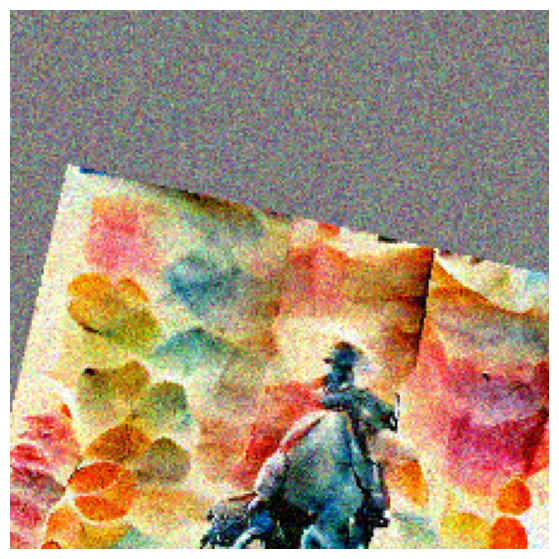

Generation


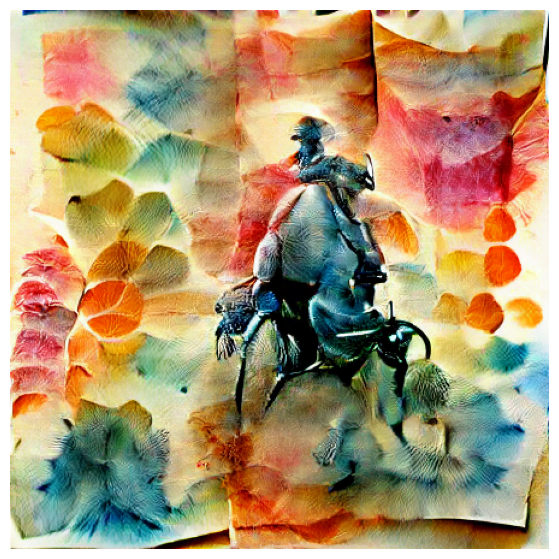

loss: -0.2310791015625 
iteration: 80
Augmented cropped example


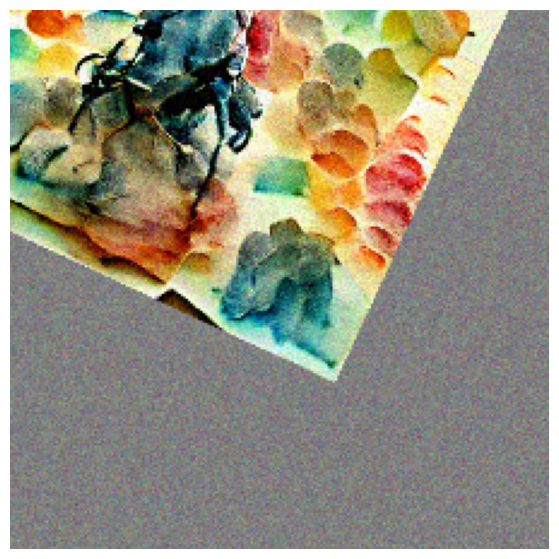

Generation


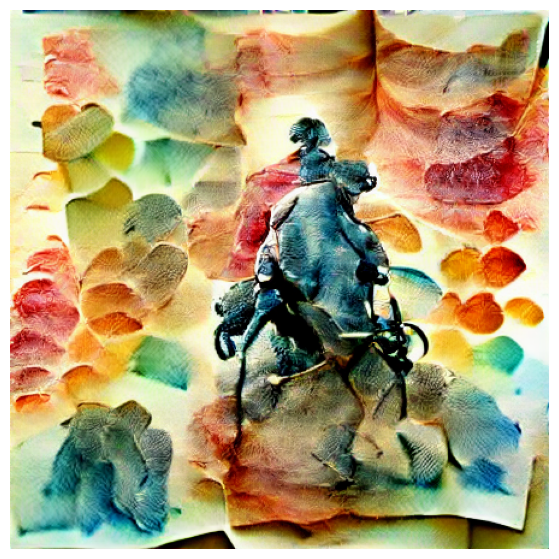

loss: -0.2301025390625 
iteration: 90


In [ ]:
torch.cuda.empty_cache()
#include=['sketch of a lady', 'sketch of a man on a horse']
include=['MAN ON A HORSE']
exclude='watermark,CROPPED'
extras = "WATERCOLOR PAPER TEXTURE"
w1=1
w2=1
noise_factor= .22
total_iter=100
show_step=10 # set this to see the result every 10 interations beyond iteration 80
include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z=training_loop(Params, optimizer, show_crop=True)


In [ ]:
print(len(res_img), len(res_z))
print(res_img[0].shape, res_z[0].shape)
print(res_z[0].max(), res_z[0].min())

2 2
torch.Size([3, 448, 448]) torch.Size([1, 256, 28, 28])
tensor(6.2859, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-6.0009, device='cuda:0', grad_fn=<MinBackward1>)


Generation


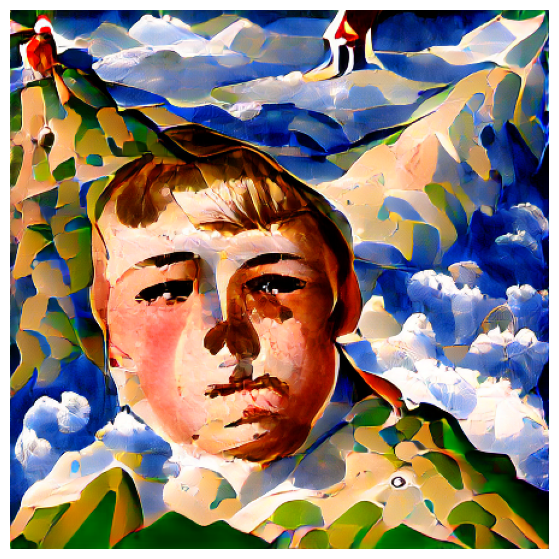

loss: -0.291748046875 
iteration: 99
Generation


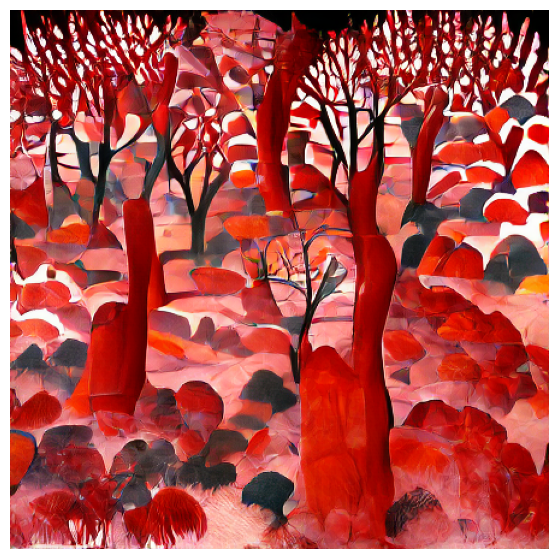

loss: -0.251708984375 
iteration: 99
Generation


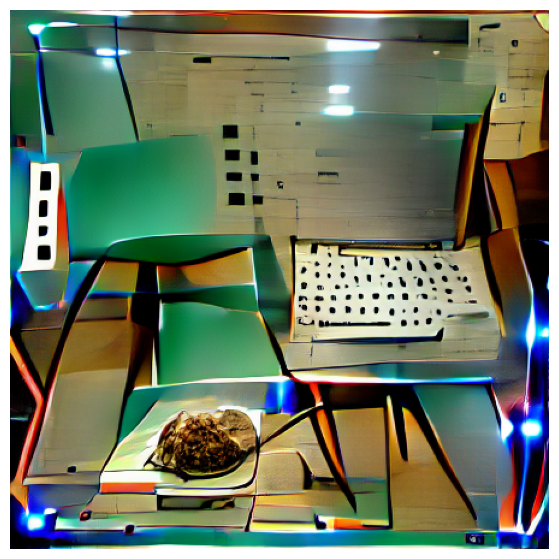

loss: -0.2259521484375 
iteration: 99
Generation


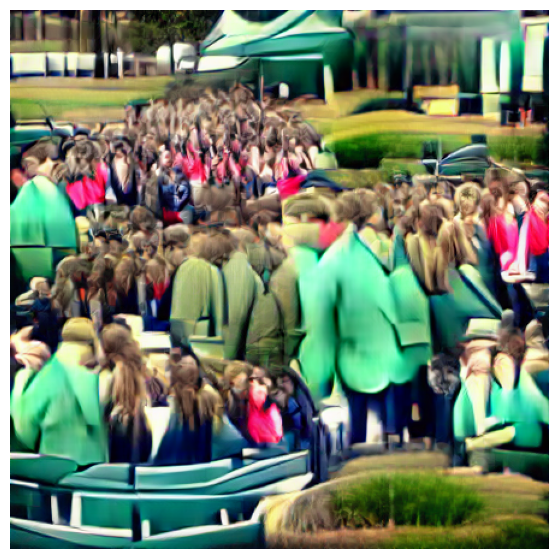

loss: -0.260986328125 
iteration: 99


In [ ]:
torch.cuda.empty_cache()
include=['A boy at the top of a  mountain ',
         'A forest with red trees',
         'computer on a table',
         'one hundred people with green jackets']
exclude='watermark, cropped, confusing, incoherent, cut, blurry'
extras = ""
w1=1
w2=1
noise_factor= .22
total_iter=100
show_step=total_iter-1 # set this if you want to interpolate between only the final versions
include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z=training_loop(Params, optimizer, show_crop=False)


In [ ]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

from torchvision.models.inception import inception_v3

import numpy as np
from scipy.stats import entropy

from glob import glob
import os
from PIL import Image
from imageio import imread

IMAGE_EXTS = ['.png', '.jpg', '.jpeg']

def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=10):
    # Code for inception_score function remains the same
    os.environ['CUDA_VISIBLE_DEVICES']='1'
    
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_weights_path = 'path/to/inception_v3_google-1a9a5a14.pth'  # Replace with the actual path to the downloaded weights file
    inception_model = inception_v3(weights=inception_weights_path, transform_input=False).type(dtype)

    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x, dim=1).data.cpu().numpy()


    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

def load_images(image_dir):
    print('Loading images from', image_dir)
    images = []
    for fn in os.listdir(image_dir):
        ext = os.path.splitext(fn)[1].lower()
        if ext not in IMAGE_EXTS:
            continue
        img_path = os.path.join(image_dir, fn)
        img = imread(img_path)
        img = (
            (np.array(Image.fromarray(img).resize((32, 32))).astype('float')) - 127.5
        ) / 127.5
        images.append(img)
    print('Found %d images' % len(images))
    return images

if __name__ == '__main__':
    # Code for IgnoreLabelDataset class remains the same

    images = res_img

    print("Calculating Inception Score...")
    print(inception_score(images, cuda=True, batch_size=1, resize=True, splits=10))

Calculating Inception Score...


KeyError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

from torchvision.models.inception import inception_v3

import numpy as np
from scipy.stats import entropy

from glob import glob
import os
from scipy import misc
from imageio import imread


IMAGE_EXTS = ['.png', '.jpg', '.jpeg']

def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=10):
    """Computes the inception score of the generated images imgs
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    
    os.environ['CUDA_VISIBLE_DEVICES']='1'
    
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

def load_images(image_dir):
  print('Loading images from ', image_dir)
  images = []
  for fn in os.listdir(image_dir):
    ext = os.path.splitext(fn)[1].lower()
    if ext not in IMAGE_EXTS:
      continue
    img_path = os.path.join(image_dir, fn)
    img = imread(img_path)
    img = ((imresize(img, (32, 32)).astype('float'))-127.5)/127.5
    images.append(img)
  print('Found %d images' % len(images))
  return images

if __name__ == '__main__':
    class IgnoreLabelDataset(torch.utils.data.Dataset):
        def __init__(self, orig):
            self.orig = orig

        def __getitem__(self, index):
            return self.orig[index][0]

        def __len__(self):
            return len(self.orig)

    import torchvision.datasets as dset
    import torchvision.transforms as transforms

#    cifar = dset.CIFAR10(root='data/', download=True,
#                             transform=transforms.Compose([
#                                 transforms.Scale(32),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
#                                 #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                             ])
#    )
#
#    IgnoreLabelDataset(cifar)    
    
    images = res_img
    

    print ("Calculating Inception Score...")
    #print (inception_score(IgnoreLabelDataset(cifar), cuda=True, batch_size=32, resize=True, splits=10))
    print (inception_score(images, cuda=True, batch_size=1, resize=True, splits=10))

In [ ]:
model=tf.keras.applications.inception_v3(include_top=False) 
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
model.trainable=False 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import entropy

def inception_score(images, inception_model, batch_size=32, splits=10):
    
    # Prepare the Inception model
    inception_model.eval()

    # Calculate the number of images
    num_images = len(images)

    # Create DataLoader to load images in batches
    dataloader = torch.utils.data.DataLoader(images, batch_size=batch_size)

    # Initialize the list to store the predicted class probabilities
    preds = []

    # Generate predictions for all images
    with torch.no_grad():
        for batch_images in dataloader:
            batch_images = batch_images.float()
            if torch.cuda.is_available():
                batch_images = batch_images.cuda()
            preds.append(F.softmax(inception_model(batch_images), dim=1).cpu().numpy())

    # Concatenate the predicted class probabilities
    preds = np.concatenate(preds)

    # Calculate the marginal class distribution for each image
    marginal_dists = preds.mean(axis=0)

    # Calculate the overall class distribution
    overall_dist = marginal_dists.mean(axis=0)

    # Calculate the KL divergences for each image
    kl_divs = entropy(marginal_dists.T, overall_dist).mean(axis=0)

    # Calculate the Inception Score
    inception_score = np.exp(np.mean(kl_divs))

    return inception_score


In [ ]:
import tensorflow as tf
import numpy as np
import scipy.stats as stats

def calculate_inception_score(generated_images, batch_size=64, splits=10):
    # Load the pre-trained Inception model
    inception_model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg')

    # Preprocess generated images
    generated_images = preprocess_images(generated_images)

    # Get the predicted class probabilities for generated images
    generated_logits = inception_model.predict(generated_images, batch_size=batch_size)
    generated_probs = tf.nn.softmax(generated_logits)

    # Calculate the conditional class distribution for generated images
    conditional_distribution = tf.reduce_mean(generated_probs, axis=0)

    # Calculate the marginal class distribution for real images (using a large dataset of real images)
    real_probs = calculate_marginal_distribution(inception_model, batch_size=batch_size)

    # Compute the KL-divergence between the conditional and marginal class distributions
    kl_divergence = stats.entropy(real_probs, conditional_distribution)

    # Calculate the exponential of the KL-divergence to obtain the Inception Score
    inception_score = np.exp(kl_divergence)

    return inception_score

def preprocess_images(images):
    # Preprocess images (resize, normalize, etc.) to match Inception model requirements
    preprocessed_images = tf.image.resize(images, (299, 299))
    preprocessed_images = tf.keras.applications.inception_v3.preprocess_input(preprocessed_images)
    return preprocessed_images

def calculate_marginal_distribution(model, batch_size):
    # Load a large dataset of real images and preprocess them
    real_images = load_real_images()  # You need to implement this function
    preprocessed_images = preprocess_images(real_images)

    # Get the predicted class probabilities for real images
    real_logits = model.predict(preprocessed_images, batch_size=batch_size)
    real_probs = tf.nn.softmax(real_logits)

    # Calculate the marginal class distribution for real images
    marginal_distribution = tf.reduce_mean(real_probs, axis=0)

    return marginal_distribution

In [ ]:
def interpolate(res_z_list):
    gen_img_list = []

    for z in res_z_list:
        new_gen = norm_data(generator(z).cpu())[0]  # 3 x 224 x 400
        new_img = T.ToPILImage(mode='RGB')(new_gen)
        gen_img_list.append(new_img)

    return gen_img_list

In [ ]:
# Generate interpolated images
gen_img_list = interpolate(res_z)

# Convert the list of PIL images to a list of tensors
generated_images = [preprocess_images(T.ToTensor()(img)) for img in gen_img_list]

# Concatenate the tensors along the batch dimension
generated_images = torch.stack(generated_images)

# Use the generated_images to calculate the Inception Score
inception_score = calculate_inception_score(generated_images)

# Print the Inception Score
print("Inception Score:", inception_score)

In [ ]:
# import tensorflow as tf
# import numpy as np
# import scipy.stats as stats

# def calculate_inception_score(generated_images, batch_size=64, splits=10):
#     # Load the pre-trained Inception model
#     inception_model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg')

#     # Preprocess generated images
#     generated_images = preprocess_images(generated_images)

#     # Get the predicted class probabilities for generated images
#     generated_logits = inception_model.predict(generated_images, batch_size=batch_size)
#     generated_probs = tf.nn.softmax(generated_logits)

#     # Calculate the conditional class distribution for generated images
#     conditional_distribution = tf.reduce_mean(generated_probs, axis=0)

#     # Calculate the marginal class distribution for real images (using a large dataset of real images)
#     real_probs = calculate_marginal_distribution(inception_model, batch_size=batch_size)

#     # Compute the KL-divergence between the conditional and marginal class distributions
#     kl_divergence = stats.entropy(real_probs, conditional_distribution)

#     # Calculate the exponential of the KL-divergence to obtain the Inception Score
#     inception_score = np.exp(kl_divergence)

#     return inception_score

# def preprocess_images(images):
#     # Preprocess images (resize, normalize, etc.) to match Inception model requirements
#     preprocessed_images = tf.image.resize(images, (299, 299))
#     preprocessed_images = tf.keras.applications.inception_v3.preprocess_input(preprocessed_images)
#     return preprocessed_images

# def calculate_marginal_distribution(model, batch_size):
#     # Load a large dataset of real images and preprocess them
#     real_images = load_real_images()  # You need to implement this function
#     preprocessed_images = preprocess_images(real_images)

#     # Get the predicted class probabilities for real images
#     real_logits = model.predict(preprocessed_images, batch_size=batch_size)
#     real_probs = tf.nn.softmax(real_logits)

#     # Calculate the marginal class distribution for real images
#     marginal_distribution = tf.reduce_mean(real_probs, axis=0)

#     return marginal_distribution


In [ ]:
# Generate a set of images using your generative model
  # You need to implement this function

# Calculate the Inception Score
inception_score = calculate_inception_score(res_z)

# Print the Inception Score
print("Inception Score:", inception_score)

In [ ]:
## create a video
out_video_path=f"../video.mp4"
writer = imageio.get_writer(out_video_path, fps=25)
for pil_img in interp_result_img_list:
  img = np.array(pil_img, dtype=np.uint8)
  writer.append_data(img)

writer.close()

In [ ]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('../video.mp4','rb').read()
data="data:video/mp4;base64,"+b64encode(mp4).decode()
HTML("""<video width=800 controls><source src="%s" type="video/mp4"></video>""" % data)